In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np

import random
from queue import *

from DataLoader import *

import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [3]:
def generate_training_data(n_iters,filename):
    data_loader = T2TDataLoader(filename)
    training_data = data_loader.get_data()
    print(len(training_data))
    training_pairs = [(random.choice(training_data))
                      for i in range(n_iters)]
    print(training_pairs[0])
    print(training_pairs[0][1].key)
    return training_pairs

In [4]:
plot_loss_avg = []
plot_losses = []

In [5]:
class Tree:
    def __init__(self,level,rootObj=None):
        self.level = level
        self.key = rootObj
        self.leftChild = None
        self.rightChild = None
        self.parent = None
        self.sibling = None
        self.children = [] 
        self.hiddenA = None
        self.hiddenF = None

In [6]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.word_embeddings = nn.Embedding(input_size, embedding_size)    
        self.lstm = nn.LSTM(input_size = embedding_size, hidden_size = hidden_size,num_layers = 1)
        

    def forward(self, input, hidden, c):
        embedded = self.word_embeddings(input).view(1, 1, -1)

        output = embedded
        output,(hidden,c) = self.lstm(output, (hidden, c))
        return output,hidden,c

    def initCells(self):
        
        if use_cuda:
            return Variable(torch.zeros(1, 1, self.hidden_size).cuda(gpu_no))
        else:
            return Variable(torch.zeros(1, 1, self.hidden_size))
        

In [7]:
class DecoderDRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, decoder_vocab_size):
        super(DecoderDRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.word_embeddings = nn.Embedding(decoder_vocab_size, embedding_dim)
        self.gruA = nn.GRU(input_size = embedding_dim, hidden_size = hidden_dim,num_layers = 1)
        self.gruF = nn.GRU(input_size = embedding_dim, hidden_size = hidden_dim,num_layers = 1)
        self.linearA1 = nn.Linear(hidden_dim,hidden_dim)
        self.linearF1 = nn.Linear(hidden_dim,hidden_dim)
        self.projA = nn.Linear(hidden_dim,1)
        self.projF = nn.Linear(hidden_dim,1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        #Note the -2
        self.vA = nn.Linear(1,decoder_vocab_size-2)
        self.vF = nn.Linear(1,decoder_vocab_size-2)
        self.predWeight = nn.Linear(hidden_dim,decoder_vocab_size-2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        init_bias = torch.from_numpy(-np.ones((1,3*hidden_dim)))
        self.gruA.bias_hh_l0.data = init_bias.float()
        self.gruF.bias_hh_l0.data = init_bias.float()
    
    def forward(self, hiddenA, hiddenF, parent, sibling):
        embeddedA = self.word_embeddings(parent).view(1, 1, -1)
        embeddedF = self.word_embeddings(sibling).view(1, 1, -1)
        outputA = embeddedA
        outputF = embeddedF
        outputA, hiddenA = self.gruA(outputA,hiddenA)
        outputF, hiddenF = self.gruF(outputF,hiddenF)
        hPred = self.tanh(self.linearA1(hiddenA.view(1,-1))+self.linearF1(hiddenF.view(1,-1)))
        childPred = self.sigmoid(self.projA(hPred))
        siblingPred = self.sigmoid(self.projF(hPred))
        
            
        output = self.predWeight(hPred.view(1,-1))
        if(torch.gt(childPred,0.5).data[0][0]):
            output += self.vA(childPred)
        if(torch.gt(siblingPred,0.5).data[0][0]):
            output += self.vF(siblingPred)       
        
        output = self.log_softmax(output)
        return hiddenA,hiddenF,childPred,siblingPred,output


In [8]:
def train(input_variable, target, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion_label,criterion_topology):
    encoder_hidden = encoder.initCells()
    encoder_c = encoder.initCells()

    input_length = len(input_variable)
    target_length = input_length

    
    if use_cuda:
        encoder_hidden = encoder_hidden.cuda()

    for ei in range(input_length):
        encoder_output, encoder_hidden,encoder_c = encoder(input_variable[ei], encoder_hidden,encoder_c)
        
    decoder_hiddenA = encoder_hidden
    decoder_hiddenF = encoder_hidden
    
    
    target_tree_root = target
    targetQ = Queue()
    targetQ.put(target_tree_root)
    
    nodesQ = Queue()
    root = Tree(level = 0)
    nodesQ.put(root)
     
    prev = root
    loss = 0
    loss_topo = 0
    loss_label = 0
    
    seq_len = 1
    while(not targetQ.empty()):
        target_node = targetQ.get()
        if(target_node.leftChild != None):
            seq_len += 2
            targetQ.put(target_node.leftChild)
            targetQ.put(target_node.rightChild)
        
        node = nodesQ.get()
        if node.parent == None:
            parent = Variable(torch.LongTensor([106]))
            #parent = 106
        else:
            parent = node.parent.key
            decoder_hiddenA = node.parent.hiddenA
        if node.sibling == None:
            #sibling = 107
            sibling = Variable(torch.LongTensor([107]))
            if node.level != 0:
                if use_cuda:
                    decoder_hiddenF = Variable(torch.zeros(1, 1, hidden_dim).cuda(gpu_no))
                else:
                    decoder_hiddenF = Variable(torch.zeros(1, 1, hidden_dim))
        else:
            sibling = node.sibling.key
            decoder_hiddenF = node.sibling.hiddenF
            
        if use_cuda:
            parent = parent.cuda(gpu_no)
            sibling = sibling.cuda(gpu_no)

        decoder_hiddenA,decoder_hiddenF,childPred,siblingPred,output= decoder(
           decoder_hiddenA, decoder_hiddenF, parent, sibling)
        
        
        if(target_node.key in target_op):
            target_node.key = target_op[target_node.key]
        
        if use_cuda:
            target_label = Variable(torch.LongTensor([int(target_node.key)])).cuda(gpu_no)
        else:
            target_label = Variable(torch.LongTensor([int(target_node.key)]))
            
        loss_label = criterion_label(output,target_label)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        loss_label.backward(retain_graph = True) 
        nn.utils.clip_grad_norm(decoder.parameters(), 5)
        nn.utils.clip_grad_norm(encoder.parameters(), 5)
        
        loss += loss_label.data[0]
        encoder_optimizer.step()
        decoder_optimizer.step()

        node.key = Variable(torch.LongTensor([int(target_node.key)]))
        node.hiddenA = decoder_hiddenA
        node.hiddenF = decoder_hiddenF
        
        
        if(target_node.leftChild is not None):
            leftChild = Tree(node.level+1)
            leftChild.parent = node

            if prev.level == leftChild.level:
                leftChild.sibling = prev

            rightChild = Tree(node.level+1)
            rightChild.parent = node
            rightChild.sibling = leftChild

            prev = rightChild

            node.children.append(leftChild)
            node.children.append(rightChild)
            node.leftChild = leftChild
            node.rightChild = rightChild
            nodesQ.put(leftChild)
            nodesQ.put(rightChild)
            
            if use_cuda:
                target_topo = Variable(torch.FloatTensor([1.0]).view(1,1)).cuda(gpu_no)
            else:
                target_topo = Variable(torch.FloatTensor([1.0]).view(1,1))
            
            loss_topo = criterion_topology(childPred,target_topo)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            loss_topo.backward(retain_graph = True)
            nn.utils.clip_grad_norm(decoder.parameters(), 5)
            nn.utils.clip_grad_norm(encoder.parameters(), 5)
            
            loss += loss_topo.data[0]
            
            encoder_optimizer.step()
            decoder_optimizer.step()
        
            
                    
        if use_cuda:
            target_topo = Variable(torch.FloatTensor([0.0]).view(1,1)).cuda(gpu_no)
        else:
            target_topo = Variable(torch.FloatTensor([0.0]).view(1,1))
        
        if(target_node.leftChild is None and torch.gt(childPred,0.5).data[0][0]):
            loss_topo = criterion_topology(childPred,target_topo)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            loss_topo.backward(retain_graph = True)
            nn.utils.clip_grad_norm(decoder.parameters(), 5)
            nn.utils.clip_grad_norm(encoder.parameters(), 5)
            
            loss += loss_topo.data[0]
            encoder_optimizer.step()
            decoder_optimizer.step() 
     

    return loss/ target_length

In [9]:
def trainIters(encoder, decoder, n_iters, training_pairs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion_label = nn.NLLLoss()
    criterion_topo = nn.BCELoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = Variable(torch.LongTensor(training_pair[0]).view(-1, 1))
        target = training_pair[1]
        
        if use_cuda:
            input_variable = input_variable.cuda(gpu_no)

        loss = train(input_variable, target, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion_label,criterion_topo)
        print_loss_total += loss
        plot_losses.append(loss)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            plot_loss_avg.append(print_loss_avg)
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))


In [10]:
hidden_dim = 256
embedding_size = 256
gpu_no = 0
# 0-99,+,-,*,/,(,)
encoder_vocab_size = 106
decoder_vocab_size = 108
use_cuda = True
n_iters = 50000
filename = "/data2/t2t/train.orig"
target_op = {'+':'100', '-':'101','*':'102','/':'103'}

training_pairs = generate_training_data(n_iters,filename)


100000
[[104, 64, 100, 36, 105], <TreeParser.BinaryTree object at 0x7fa89e4852b0>, 2]
+


In [11]:
encoder1 = EncoderLSTM(encoder_vocab_size, hidden_dim,embedding_size)
decoder1 = DecoderDRNN(embedding_size,hidden_dim,decoder_vocab_size)


if use_cuda:
    encoder1 = encoder1.cuda(gpu_no)
    decoder1 = decoder1.cuda(gpu_no)

trainIters(encoder1,decoder1, n_iters, training_pairs,print_every=100)

0m 6s (- 51m 10s) (100 0%) 2.4465
0m 12s (- 51m 30s) (200 0%) 2.1983
0m 18s (- 51m 29s) (300 0%) 2.1759
0m 24s (- 51m 28s) (400 0%) 2.1643
0m 30s (- 50m 59s) (500 1%) 2.1744
0m 37s (- 51m 13s) (600 1%) 2.1747
0m 44s (- 52m 16s) (700 1%) 2.1286
0m 51s (- 52m 46s) (800 1%) 2.1415
0m 57s (- 52m 14s) (900 1%) 2.1169
1m 3s (- 51m 52s) (1000 2%) 2.1094
1m 9s (- 51m 37s) (1100 2%) 2.0832
1m 16s (- 51m 35s) (1200 2%) 2.0480
1m 22s (- 51m 23s) (1300 2%) 1.9378
1m 28s (- 51m 11s) (1400 2%) 1.8968
1m 34s (- 51m 0s) (1500 3%) 1.8932
1m 40s (- 50m 38s) (1600 3%) 1.8366
1m 46s (- 50m 24s) (1700 3%) 1.8321
1m 52s (- 50m 14s) (1800 3%) 1.7732
1m 58s (- 50m 9s) (1900 3%) 1.7808
2m 4s (- 49m 57s) (2000 4%) 1.7946
2m 11s (- 49m 50s) (2100 4%) 1.8006
2m 17s (- 49m 46s) (2200 4%) 1.7787
2m 23s (- 49m 33s) (2300 4%) 1.7173
2m 29s (- 49m 26s) (2400 4%) 1.7786
2m 35s (- 49m 15s) (2500 5%) 1.7434
2m 41s (- 49m 2s) (2600 5%) 1.7530
2m 47s (- 48m 53s) (2700 5%) 1.7434
2m 53s (- 48m 38s) (2800 5%) 1.7368
2m 58s (

19m 1s (- 24m 12s) (22000 44%) 0.0433
19m 6s (- 24m 6s) (22100 44%) 0.0277
19m 10s (- 24m 1s) (22200 44%) 0.0543
19m 15s (- 23m 55s) (22300 44%) 0.0489
19m 20s (- 23m 50s) (22400 44%) 0.0501
19m 25s (- 23m 44s) (22500 45%) 0.0387
19m 30s (- 23m 38s) (22600 45%) 0.0317
19m 35s (- 23m 33s) (22700 45%) 0.0293
19m 39s (- 23m 27s) (22800 45%) 0.0325
19m 44s (- 23m 22s) (22900 45%) 0.0292
19m 49s (- 23m 16s) (23000 46%) 0.0375
19m 54s (- 23m 11s) (23100 46%) 0.0385
19m 59s (- 23m 5s) (23200 46%) 0.0393
20m 4s (- 23m 0s) (23300 46%) 0.0312
20m 10s (- 22m 55s) (23400 46%) 0.0355
20m 15s (- 22m 50s) (23500 47%) 0.0308
20m 20s (- 22m 45s) (23600 47%) 0.0219
20m 25s (- 22m 40s) (23700 47%) 0.0317
20m 31s (- 22m 35s) (23800 47%) 0.0312
20m 36s (- 22m 30s) (23900 47%) 0.0342
20m 41s (- 22m 25s) (24000 48%) 0.0273
20m 47s (- 22m 20s) (24100 48%) 0.0368
20m 52s (- 22m 15s) (24200 48%) 0.0343
20m 57s (- 22m 10s) (24300 48%) 0.0272
21m 3s (- 22m 5s) (24400 48%) 0.0250
21m 8s (- 22m 0s) (24500 49%) 0.03

37m 50s (- 5m 45s) (43400 86%) 0.0057
37m 55s (- 5m 40s) (43500 87%) 0.0041
38m 1s (- 5m 34s) (43600 87%) 0.0026
38m 6s (- 5m 29s) (43700 87%) 0.0039
38m 11s (- 5m 24s) (43800 87%) 0.0026
38m 17s (- 5m 19s) (43900 87%) 0.0039
38m 22s (- 5m 13s) (44000 88%) 0.0040
38m 27s (- 5m 8s) (44100 88%) 0.0035
38m 32s (- 5m 3s) (44200 88%) 0.0041
38m 38s (- 4m 58s) (44300 88%) 0.0042
38m 43s (- 4m 53s) (44400 88%) 0.0029
38m 48s (- 4m 47s) (44500 89%) 0.0029
38m 54s (- 4m 42s) (44600 89%) 0.0031
38m 59s (- 4m 37s) (44700 89%) 0.0039
39m 4s (- 4m 32s) (44800 89%) 0.0046
39m 10s (- 4m 26s) (44900 89%) 0.0045
39m 15s (- 4m 21s) (45000 90%) 0.0030
39m 20s (- 4m 16s) (45100 90%) 0.0038
39m 25s (- 4m 11s) (45200 90%) 0.0032
39m 31s (- 4m 6s) (45300 90%) 0.0041
39m 36s (- 4m 0s) (45400 90%) 0.0035
39m 41s (- 3m 55s) (45500 91%) 0.0034
39m 47s (- 3m 50s) (45600 91%) 0.0037
39m 52s (- 3m 45s) (45700 91%) 0.0032
39m 57s (- 3m 39s) (45800 91%) 0.0030
40m 3s (- 3m 34s) (45900 91%) 0.0029
40m 8s (- 3m 29s) (4

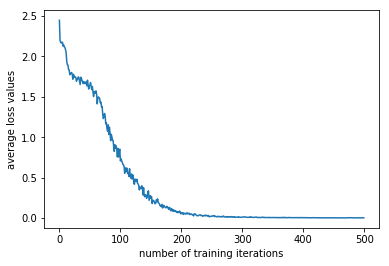

In [15]:
# Initialize the plot
fig = plt.plot(list(range(len(plot_loss_avg))),plot_loss_avg)
plt.ylabel('average loss values')
plt.xlabel('number of training iterations')
plt.show()